## 모듈 및 데이터 로드

In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 140 kB/s 


In [ ]:
import datetime
import pickle
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/날씨')
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import itertools




import pandas as pd
import pandas_profiling
import numpy as np
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid' )
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
pyo.init_notebook_mode()
#import scikitplot

from scipy import stats


import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn.utils.fixes import loguniform
from sklearn import model_selection
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb 
import xgboost as xgb
#import catboost as cb
import statsmodels.api as sm


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with open("/content/drive/MyDrive/날씨/lgb_df.pkl","rb") as fr:
    data = pickle.load(fr)
df = data.copy()

## 함수 

In [ ]:
kfcv = model_selection.KFold(10,shuffle=True,random_state=42)

In [ ]:
tcv = model_selection.TimeSeriesSplit(10)

In [ ]:
def  stn_split(df:pd.DataFrame,spn_num :int)->pd.DataFrame:
  if 'stn' in df.columns:
    df_stn_num = df.loc[df['stn']==spn_num,:]
    df_stn_num = df_stn_num.drop(['stn'],axis=1)
    return df_stn_num  

def stationarity_test(df:pd.Series)-> (pd.DataFrame,pd.DataFrame):
  Stationarity_kpss = sm.tsa.stattools.kpss(df)
  Stationarity_kpss_df = pd.Series(Stationarity_kpss[0:3],
                                   index=['Test Statistics', 'p-value', 'Used Lag'])
  for key, value in Stationarity_kpss[3].items():
    Stationarity_kpss_df[f'Critical Value {key}'] = value
  Stationarity_kpss_df = pd.DataFrame(Stationarity_kpss_df, columns=['Stationarity_kpss'])
  
  Stationarity_adf = sm.tsa.stattools.adfuller(df)
  Stationarity_adf_df = pd.Series(Stationarity_adf[0:4],
                                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
  for key, value in Stationarity_adf[4].items():
    Stationarity_adf_df[f'Critical Value {key}'] = value
  Stationarity_adf_df['Maximum Information Criteria'] = Stationarity_adf[5]
  Stationarity_adf_df = pd.DataFrame(Stationarity_adf_df, columns=['Stationarity_adf'])

  return pd.merge(Stationarity_kpss_df, Stationarity_adf_df, left_index=True,  right_index = True , how ='outer')

In [ ]:
def time_feature(df:pd.DataFrame,x:str)->pd.DataFrame:
  x_list = ['solarza','esr','band1','band2','band3','band4','band6','band7','band12']
  df_feature = df.copy()
  for n in [1,144]:
    if f'{x}_{n}' not in df_feature.columns:
      df_feature[f'{x}_{n}'] = df_feature[x].diff(n).bfill()
  if f'{x}_ma' not in df_feature.columns:
    df_feature[f'{x}_ma'] = df_feature[x].rolling(24).mean().bfill()

In [ ]:
def x_diff(df:pd.DataFrame,x:str,n:int)->pd.DataFrame:
  df_diff = df.copy()
  if f'{x}_{n}' not in df_diff.columns:
    df_diff[f'{x}_{n}'] = df_diff[x].diff(n).bfill()
  return df_diff

In [ ]:
def x_rolling(df:pd.DataFrame,x:str)->pd.DataFrame:
  df_rolling = df.copy()
  if f'{x}_ma' not in df_rolling.columns:
    df_rolling[f'{x}_ma'] = df_rolling[x].rolling(24).mean().bfill()
  return df_rolling

## Y 변환

In [ ]:
lgbr = lgb.LGBMRegressor(n_jobs=-1,randoms_state=42)
cbr = cb.CatBoostRegressor(random_state=42)
ef = ensemble.ExtraTreesRegressor(n_jobs=-1,random_state=42)
#rf = ensemble.RandomForestRegressor(n_jobs=-1,random_state=42)
xbgr = xgb.XGBRegressor(random_state=42)
knn = KNeighborsRegressor(n_jobs=-1)
models = [
          lgbr,
          cbr,
          ef,
          xbgr,
          knn]

In [ ]:
df_log_146  =  df_146.copy()
df_log_146['uv']= np.log(df_log_146['uv'] + 1 )

In [ ]:
redf_146.head()

,uv,band1,band2,band3,band4,band5,band6,band7,band8,band9,...,solarza,esr,Month sin,Month cos,Day sin,Day cos,2/Day sin,2/Day cos,3/Day sin,3/Day cos
date_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.009279,0.009286,0.011649,0.009053,0.022140,0.019418,0.530798,0.652074,0.742375,...,0.977453,0.004724,0.487099,0.999834,0.500000,1.000000,0.500000,1.000000,0.500000,1.000000
2020-01-01 00:10:00,0.0,0.009771,0.009286,0.009657,0.010204,0.020569,0.019418,0.526175,0.652074,0.741947,...,0.985220,0.004724,0.487816,0.999852,0.521810,0.999524,0.543578,0.998097,0.565263,0.995722
2020-01-01 00:20:00,0.0,0.009771,0.009286,0.011077,0.009565,0.020569,0.019418,0.527341,0.647400,0.739378,...,0.991473,0.004724,0.488532,0.999868,0.543578,0.998097,0.586824,0.992404,0.629410,0.982963
2020-01-01 00:30:00,0.0,0.009771,0.009286,0.012497,0.010076,0.021617,0.019418,0.528500,0.648962,0.739806,...,0.995874,0.004724,0.489249,0.999884,0.565263,0.995722,0.629410,0.982963,0.691342,0.961940
2020-01-01 00:40:00,0.0,0.008796,0.009286,0.011649,0.009948,0.020569,0.018440,0.528500,0.650520,0.740235,...,0.998059,0.004724,0.489966,0.999899,0.586824,0.992404,0.671010,0.969846,0.750000,0.933013


In [ ]:
cv_list = [kfcv,tcv]
result = {'transform':[],'model':[], 'rmse' :[],'cv':[]}
search_y_list = [df_log_146,df_146]
for i,search_y_df in tqdm(enumerate(search_y_list)):
  for cv in tqdm(cv_list):
    for model in tqdm(models):
      scores = model_selection.cross_val_score(model,
                                               X=search_y_df.iloc[:,1:],
                                               y=search_y_df['uv'],
                                               cv=cv,n_jobs=-1,
                                               scoring='neg_root_mean_squared_error')
      score = np.mean(scores)
      if i==0:
        result['transform'].append('log')
      else: 
        result['transform'].append('Orignal')
      result['model'].append(model)
      result['rmse'].append(score)
      result['cv'].append(cv)

0it [00:00, ?it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:40, 10.21s/it]

 40%|████      | 2/5 [02:50<04:55, 98.40s/it]

 60%|██████    | 3/5 [06:40<05:17, 158.70s/it]

 80%|████████  | 4/5 [07:25<01:53, 113.60s/it]

100%|██████████| 5/5 [09:38<00:00, 115.70s/it]

 50%|█████     | 1/2 [09:38<09:38, 578.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:06<00:24,  6.19s/it]

 40%|████      | 2/5 [01:59<03:28, 69.46s/it]

 60%|██████    | 3/5 [03:46<02:52, 86.19s/it]

 80%|████████  | 4/5 [04:12<01:02, 62.69s/it]

100%|██████████| 5/5 [05:15<00:00, 63.16s/it]

100%|██████████| 2/2 [14:54<00:00, 447.18s/it]
1it [14:54, 894.37s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:08<00:33,  8.44s/it]

 40%|████      | 2/5 [02:46<04:49, 96.48s/it]

 60%|██████    | 3/5 [06:45<05:23, 161.67s/it]

 80%|████████  | 4/5 [07:30<01:55, 115.38s/it]

100%

In [ ]:
pd.DataFrame(result)

,transform,model,rmse,cv
0,log,LGBMRegressor(randoms_state=42),-0.121333,"KFold(n_splits=10, random_state=42, shuffle=True)"
1,log,<catboost.core.CatBoostRegressor object at 0x7...,-0.107765,"KFold(n_splits=10, random_state=42, shuffle=True)"
2,log,"ExtraTreesRegressor(n_jobs=-1, random_state=42)",-0.108454,"KFold(n_splits=10, random_state=42, shuffle=True)"
3,log,XGBRegressor(random_state=42),-0.147093,"KFold(n_splits=10, random_state=42, shuffle=True)"
4,log,KNeighborsRegressor(n_jobs=-1),-0.137215,"KFold(n_splits=10, random_state=42, shuffle=True)"
5,log,LGBMRegressor(randoms_state=42),-0.167357,"TimeSeriesSplit(gap=0, max_train_size=None, n_..."
6,log,<catboost.core.CatBoostRegressor object at 0x7...,-0.171766,"TimeSeriesSplit(gap=0, max_train_size=None, n_..."
7,log,"ExtraTreesRegressor(n_jobs=-1, random_state=42)",-0.166700,"TimeSeriesSplit(gap=0, max_train_size=None, n_..."
8,log,XGBRegressor(random_state=42),-0.164918,"TimeSeriesSplit(gap=0, max_train_size=None, n_..."
9,log,KNeighborsRegressor(n_jobs=-1),-0.262533,"TimeSeriesSplit(gap=0, max_train_size=None, n_..."


In [ ]:
np.exp(0.121333)

1.1290008070461528

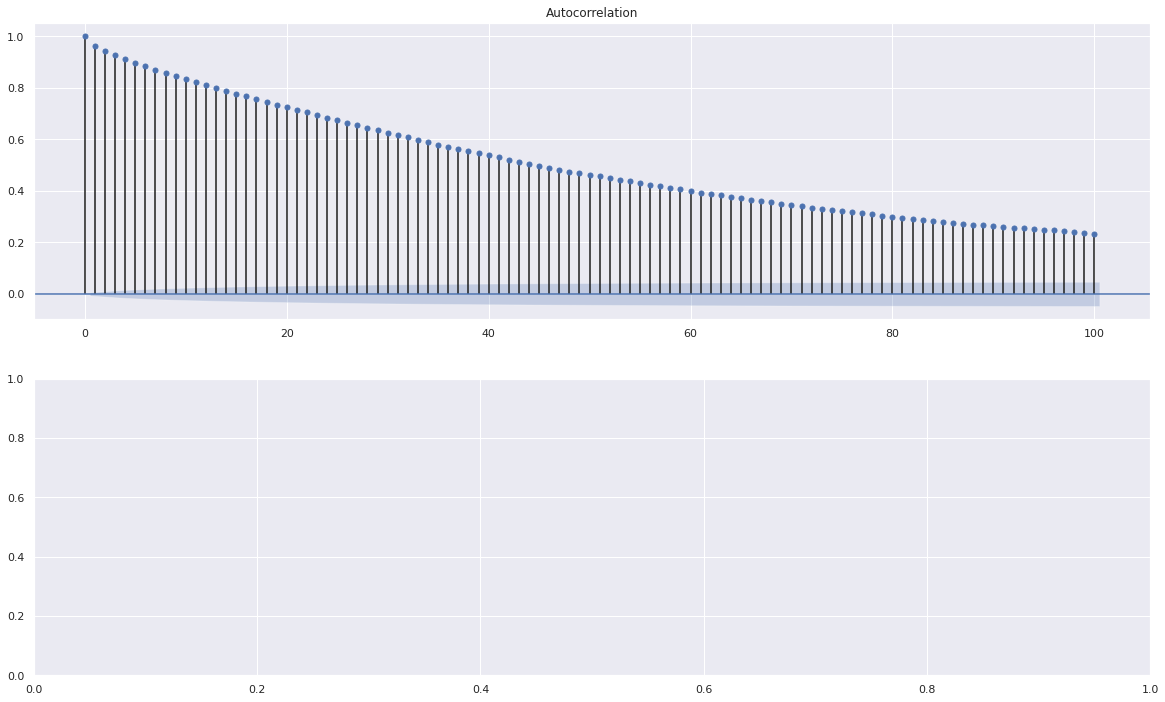

In [ ]:
%matplotlib inline 
figure, axes = plt.subplots(2,1,figsize=(20,12))

# 약한 상관성
figure = sm.graphics.tsa.plot_acf(df_146['band9'], lags=100, use_vlines=True, ax=axes[0])

# 강한 상관성
#figure = sm.graphics.tsa.plot_pacf(df_146['band1'], lags=100, use_vlines=True, ax=axes[1])

In [ ]:
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

In [ ]:
sm.tsa.stattools.adfuller(df_146['uv'])

(-44.98493537777076,
 0.0,
 69,
 105194,
 {'1%': -3.430412165708871,
  '10%': -2.566784624662082,
  '5%': -2.861567476284323},
 37502.67442811452)

In [ ]:
#sdsdsd
def stationarity_adf_test(df:pd.Series)->pd.DataFrame:
    Stationarity_adf = sm.tsa.stattools.adfuller(df)
    Stationarity_adf_df = pd.Series(Stationarity_adf[0:4],
                                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in Stationarity_adf[4].items():
        Stationarity_adf_df[f'Critical Value {key}'] = value
    Stationarity_adf_df['Maximum Information Criteria'] = Stationarity_adf[5]
    Stationarity_adf_df = pd.DataFrame(Stationarity_adf_df, columns=['Stationarity_adf'])
    return Stationarity_adf_df

In [ ]:
stationarity_adf_test(df_146['band12'])

,Stationarity_adf
Test Statistics,-26.773583
p-value,0.000000
Used Lag,23.000000
Used Observations,105240.000000
Critical Value 1%,-3.430412
Critical Value 5%,-2.861567
Critical Value 10%,-2.566785
Maximum Information Criteria,-334288.185503


In [ ]:
sm.tsa.stattools.kpss(df['uv'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



(2.733924141072935,
 0.01,
 135,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [ ]:
def kpss_test(df:pd.DataFrame)->pd.DataFrame:
      Stationarity_kpss = sm.tsa.stattools.kpss(df)
      Stationarity_kpss_df = pd.Series(Stationarity_kpss[0:3],
                                    index=['Test Statistics', 'p-value', 'Used Lag'])
      for key, value in Stationarity_kpss[3].items():
          Stationarity_kpss_df[f'Critical Value {key}'] = value
      Stationarity_kpss_df = pd.DataFrame(Stationarity_kpss_df, columns=['Stationarity_kpss'])
      return Stationarity_kpss_df

In [ ]:
p_value = { 'band':[],'p_value':[]}
for col in [x for x in df_146.columns if x[0]=='b']:
  p_value['p_value'].append(kpss_test(df[col])[1:2].values)
  p_value['band'].append(col)

In [ ]:
pd.DataFrame(p_value)

,band,p_value
0,band1,[[0.1]]
1,band2,[[0.01]]
2,band3,[[0.1]]
3,band4,[[0.030833095120935315]]
4,band5,[[0.01]]
5,band6,[[0.01]]
6,band7,[[0.01]]
7,band8,[[0.01]]
8,band9,[[0.01]]
9,band10,[[0.01]]


In [ ]:
lgbr = lgb.LGBMRegressor(n_jobs=-1,randoms_state=42)
cbr = cb.CatBoostRegressor(random_state=42)
ef = ensemble.ExtraTreesRegressor(n_jobs=-1,random_state=42)
rf = ensemble.RandomForestRegressor(n_jobs=-1,random_state=42)
xbgr = xgb.XGBRegressor(random_state=42)
knn = KNeighborsRegressor(n_jobs=-1)
models = [
          lgbr,
          cbr,
          ef,
          xbgr,
          rf]
for model in tqdm(models):
  model.fit(df_146.iloc[:,1:],df_146['uv'])


<Figure size 1440x1440 with 0 Axes>

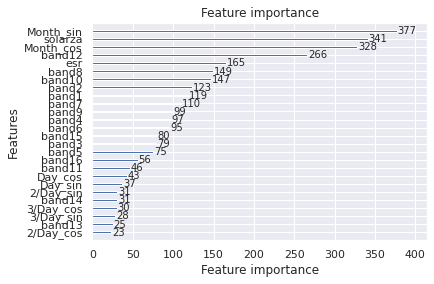

In [ ]:
plt.figure(figsize=(20,20))
lgb.plot_importance(lgbr)

In [ ]:
from sklearn.inspection import permutation_importance

5it [04:57, 59.42s/it]


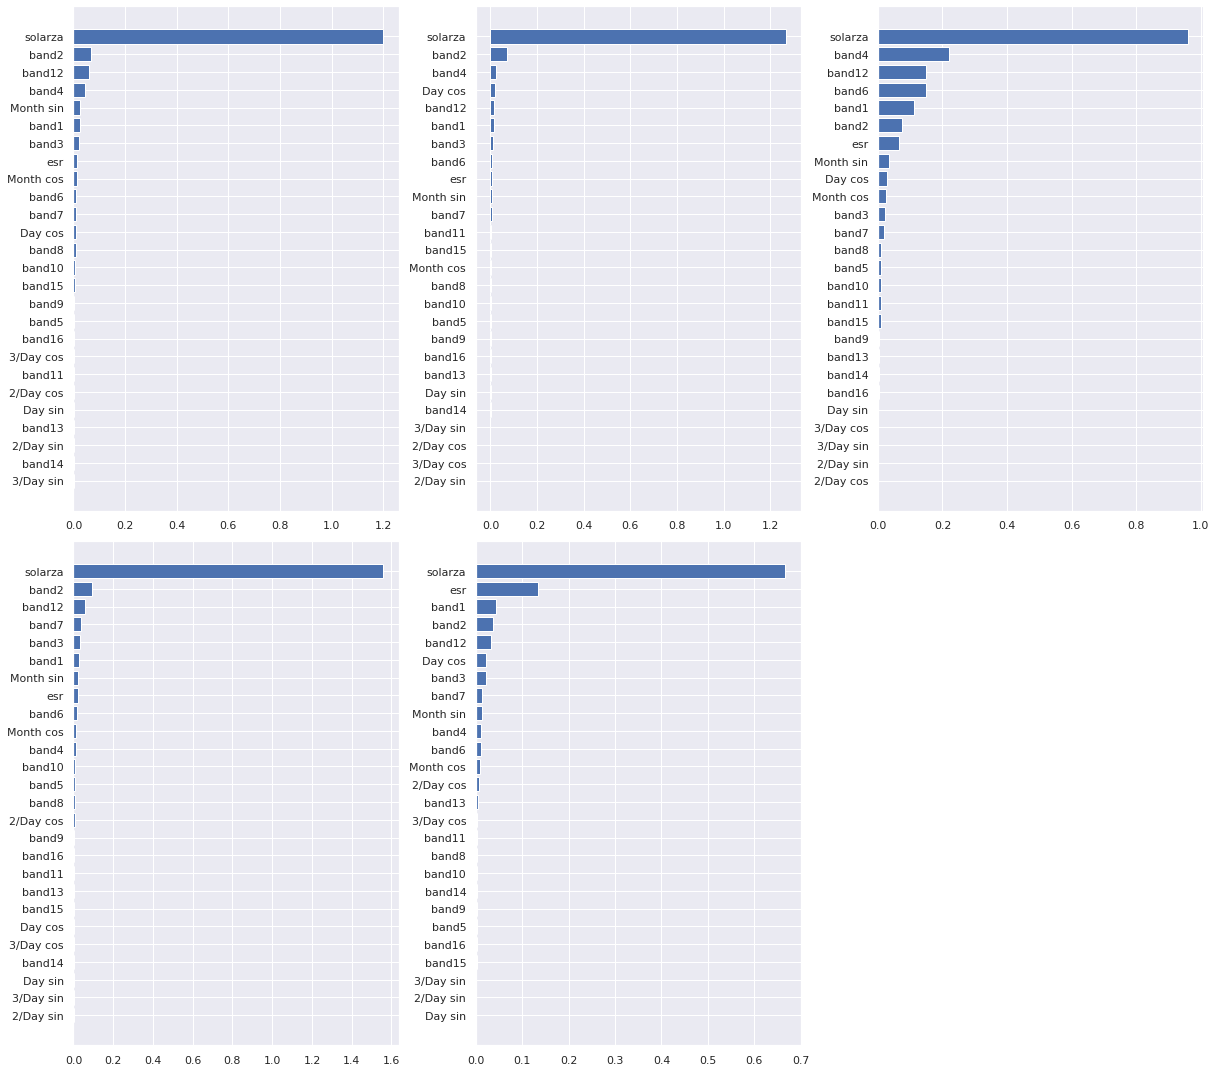

In [ ]:
fig = plt.figure(figsize=(17,15))
ax = [] 
for i in range(1,6):
  ax.append(fig.add_subplot(2,3,i))

for i,model in tqdm(enumerate([lgbr,xbgr,cbr,rf,ef])):
  result = permutation_importance(model,
                                  df_146.iloc[:,1:],
                                  df_146['uv'],
                                  random_state=42)
  sorted_idx = result.importances
  sorted_idx = result.importances_mean.argsort()
  ax[i].barh(df_146.iloc[:,1:].columns[sorted_idx],
           result.importances_mean[sorted_idx]) 

plt.tight_layout()

- band2 band12, band4 ,band1 band6 band7  band3 band12

In [ ]:
x_list = ['solarza','esr','band1','band2','band3','band4','band6','band7','band12']

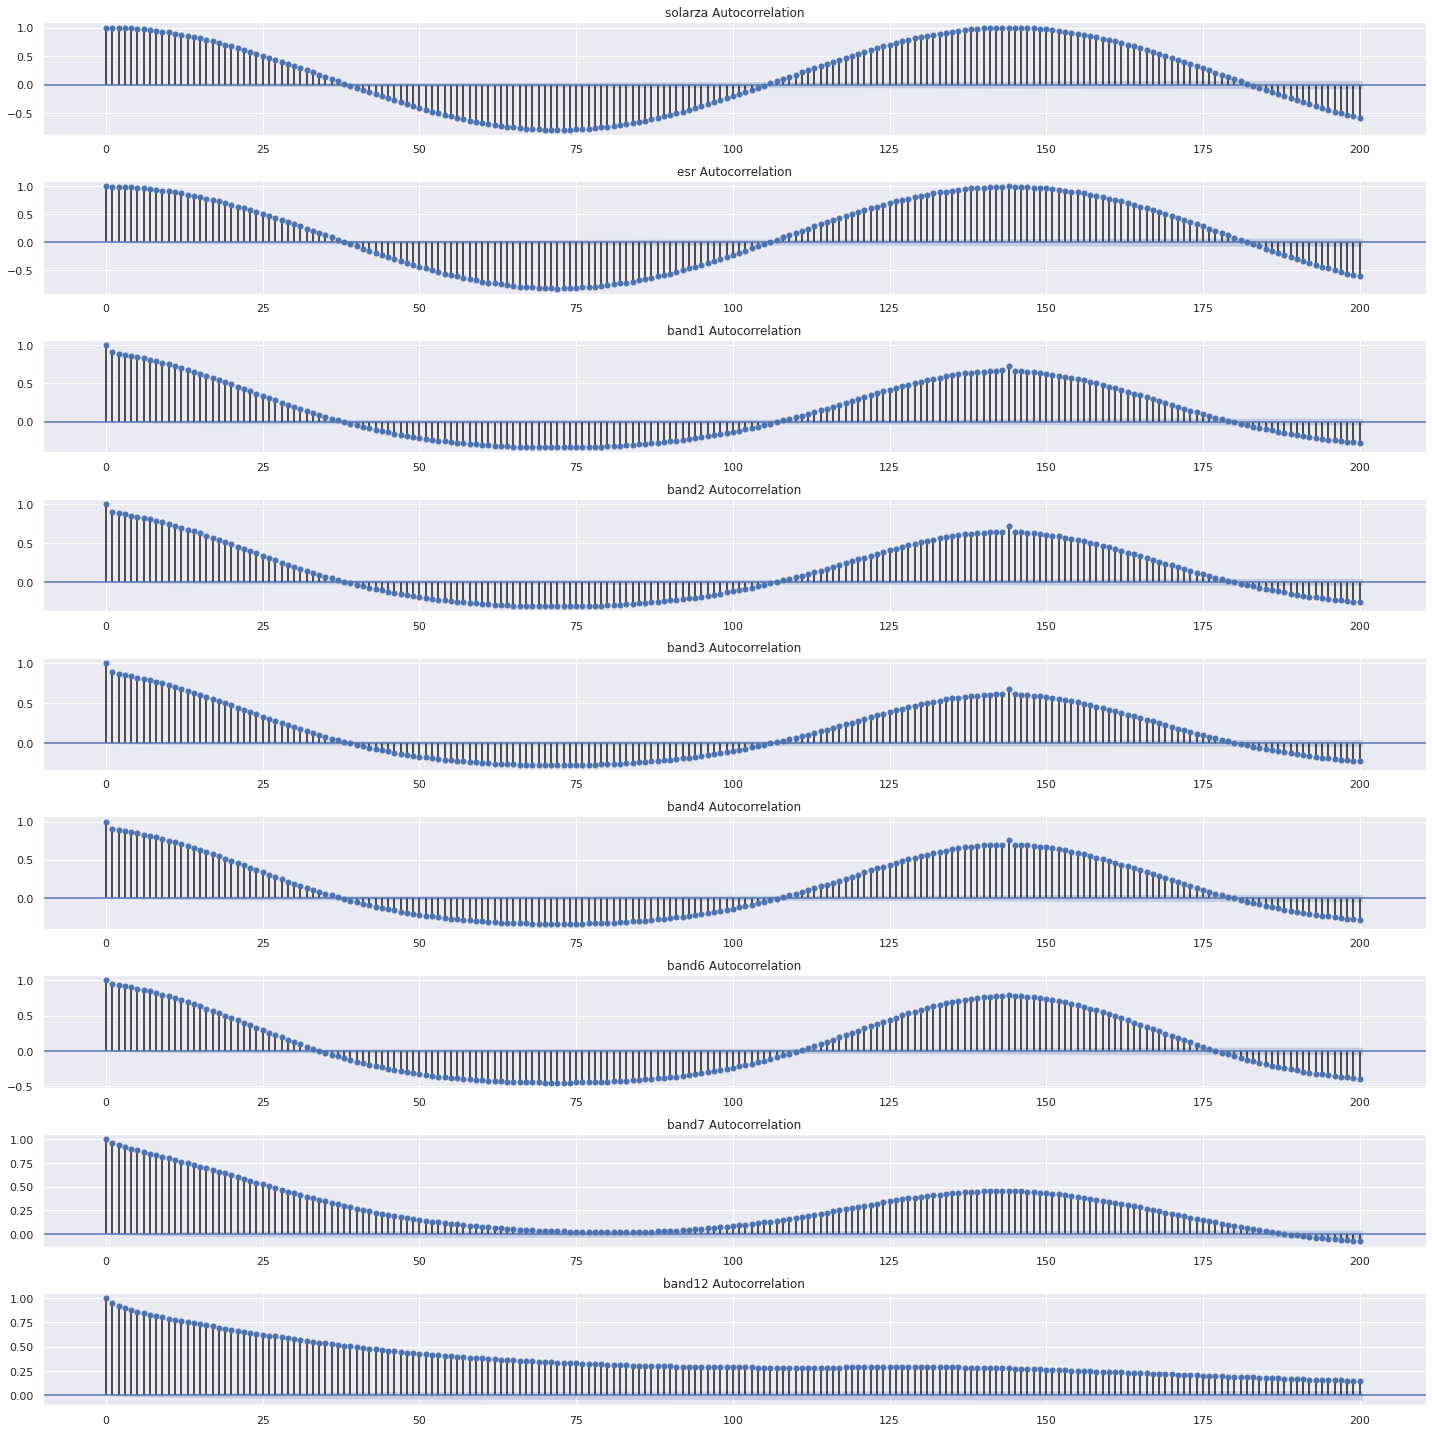

In [ ]:
%matplotlib inline 
fig = plt.figure(figsize=(20,20))
ax = []
for i in range(1,10):
  ax.append(fig.add_subplot(9,1,i))
for i,x in enumerate(x_list):
  sm.graphics.tsa.plot_acf(df_146[x], lags=200, use_vlines=True, ax=ax[i],title=f'{x} Autocorrelation')
plt.tight_layout()

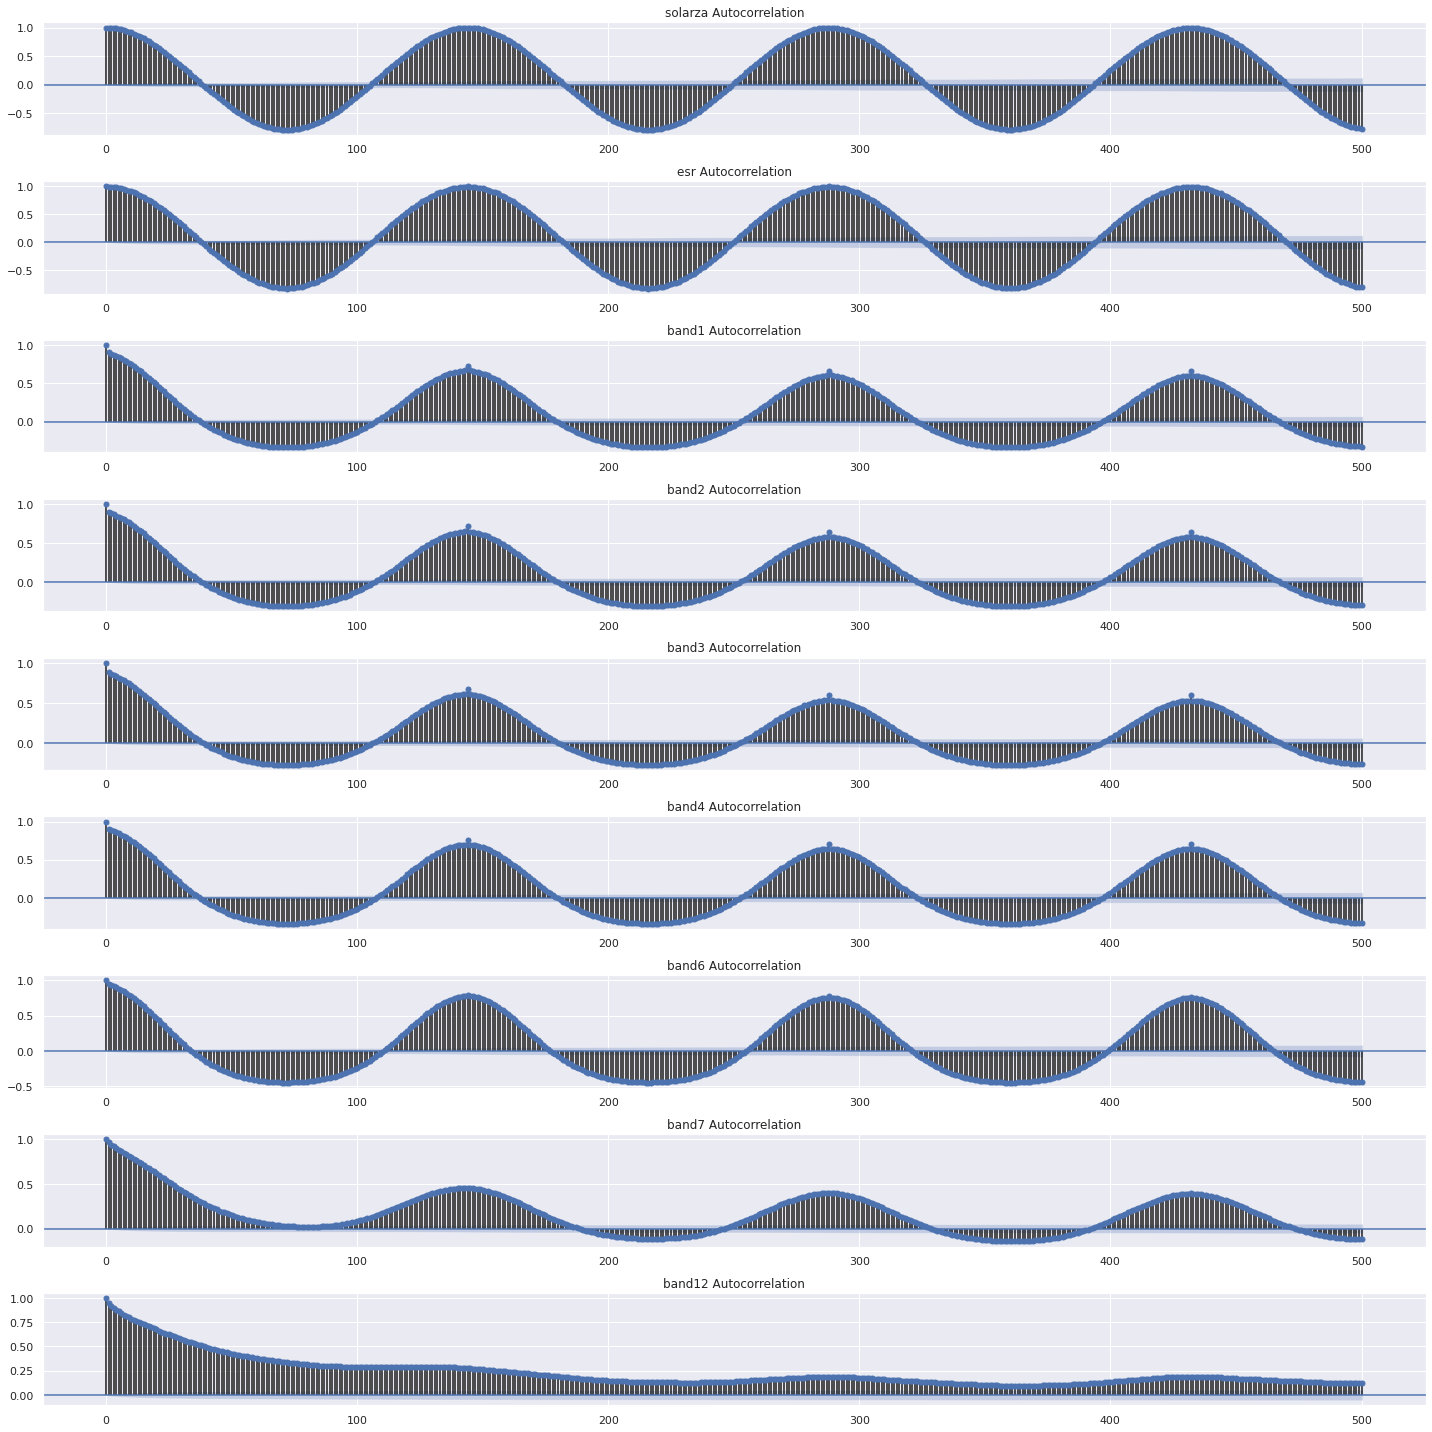

In [ ]:
%matplotlib inline 
fig = plt.figure(figsize=(20,20))
ax = []
for i in range(1,10):
  ax.append(fig.add_subplot(9,1,i))
for i,x in enumerate(x_list):
  sm.graphics.tsa.plot_acf(df_146[x], lags=500, use_vlines=True, ax=ax[i],title=f'{x} Autocorrelation')
plt.tight_layout()

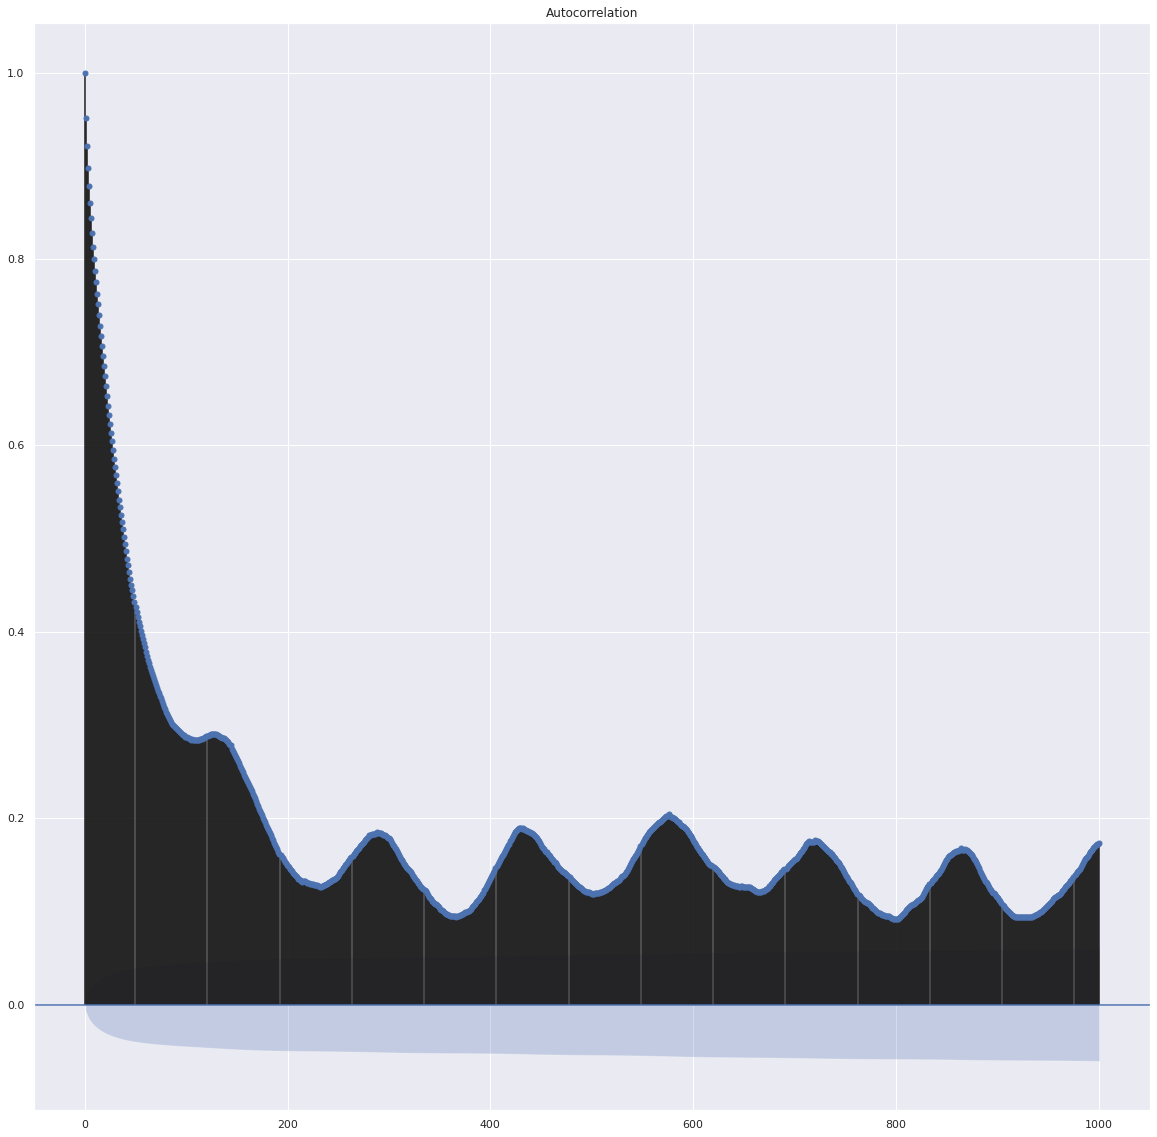

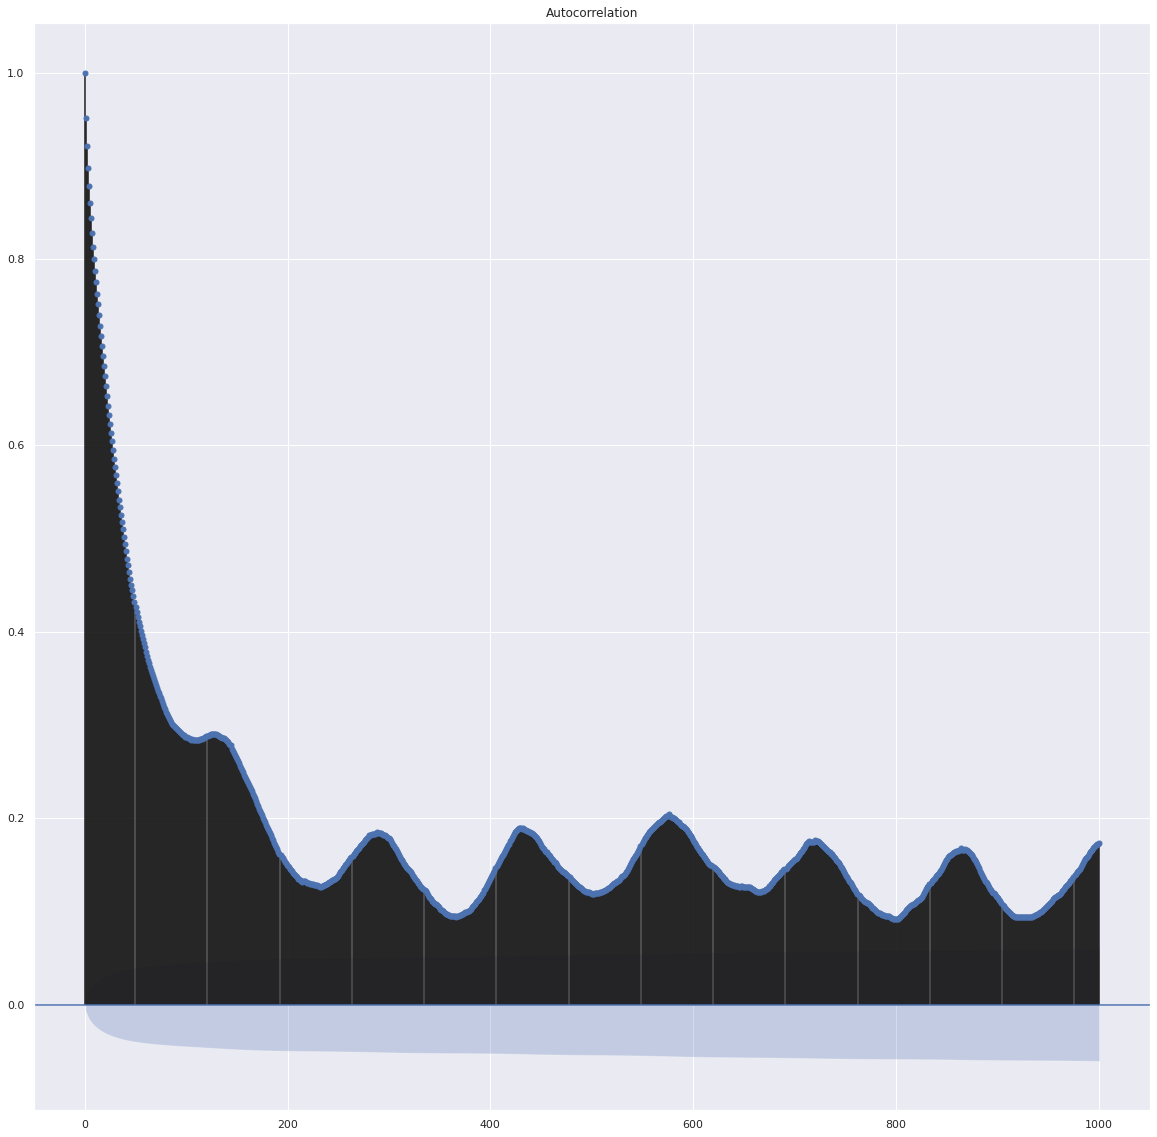

In [ ]:
%matplotlib inline 
fig= plt.figure(figsize=(20,20))
ax = plt.subplot(1,1,1)
sm.graphics.tsa.plot_acf(df_146['band12'], lags=1000, use_vlines=True, ax=ax)

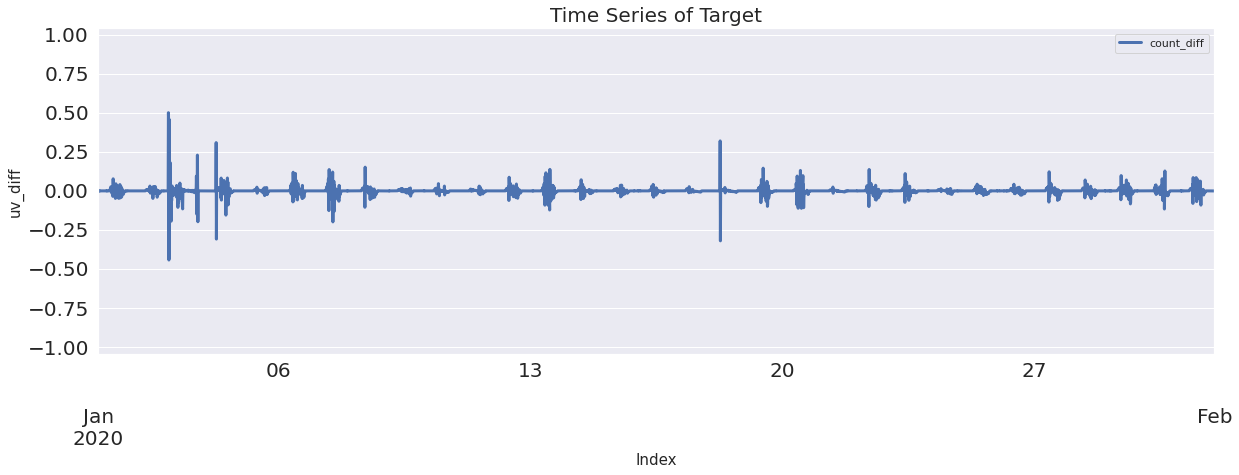

In [ ]:
# line plot of Y for specific periods
df_146[['band1']].diff(1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2020-01-01', '2020-02-01'),)
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('uv_diff', fontsize=15)
plt.legend(['count_diff'])
plt.show()

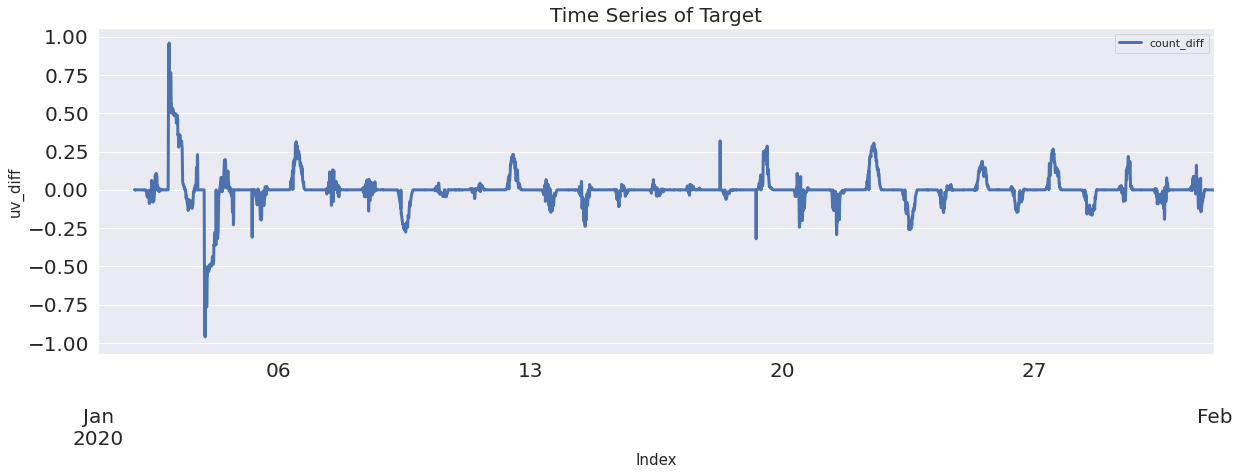

In [ ]:
df_146[['band1']].diff(144).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2020-01-01', '2020-02-01'),)
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('uv_diff', fontsize=15)
plt.legend(['count_diff'])
plt.show()

In [ ]:
def kpss_test(df:pd.Series)->pd.DataFrame:
      Stationarity_kpss = sm.tsa.stattools.kpss(df)
      Stationarity_kpss_df = pd.Series(Stationarity_kpss[0:3],
                                    index=['Test Statistics', 'p-value', 'Used Lag'])
      for key, value in Stationarity_kpss[3].items():
          Stationarity_kpss_df[f'Critical Value {key}'] = value
      Stationarity_kpss_df = pd.DataFrame(Stationarity_kpss_df, columns=['Stationarity_kpss'])
      return Stationarity_kpss_df

In [ ]:
kpss_test(df_146['band1'].diff(1).dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



,Stationarity_kpss
Test Statistics,0.000357
p-value,0.100000
Used Lag,69.000000
Critical Value 10%,0.347000
Critical Value 5%,0.463000
Critical Value 2.5%,0.574000
Critical Value 1%,0.739000


In [ ]:
df_146[['band1']].diff(1)

,band1
date_time,
2020-01-01 00:00:00,NaN
2020-01-01 00:10:00,0.000492
2020-01-01 00:20:00,0.000000
2020-01-01 00:30:00,0.000000
2020-01-01 00:40:00,-0.000974
...,...
2021-12-31 23:10:00,0.000000
2021-12-31 23:20:00,0.000000
2021-12-31 23:30:00,0.000492


In [ ]:
def adf_test(df:pd.Series)->pd.DataFrame:
    Stationarity_adf = sm.tsa.stattools.adfuller(df)
    Stationarity_adf_df = pd.Series(Stationarity_adf[0:4],
                                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in Stationarity_adf[4].items():
        Stationarity_adf_df[f'Critical Value {key}'] = value
    Stationarity_adf_df['Maximum Information Criteria'] = Stationarity_adf[5]
    Stationarity_adf_df = pd.DataFrame(Stationarity_adf_df, columns=['Stationarity_adf'])
    return Stationarity_adf_df

In [ ]:
adf_test(df_146['band1'].diff(1).dropna())

,Stationarity_adf
Test Statistics,-54.012197
p-value,0.000000
Used Lag,69.000000
Used Observations,105193.000000
Critical Value 1%,-3.430412
Critical Value 5%,-2.861567
Critical Value 10%,-2.566785
Maximum Information Criteria,-323470.493868


In [ ]:
stationarity_test(df_146['band1'].diff(1).dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



,Stationarity_kpss,Stationarity_adf
Critical Value 1%,0.739000,-3.430412
Critical Value 10%,0.347000,-2.566785
Critical Value 2.5%,0.574000,NaN
Critical Value 5%,0.463000,-2.861567
Maximum Information Criteria,NaN,-323470.493868
Test Statistics,0.000357,-54.012197
Used Lag,69.000000,69.000000
Used Observations,NaN,105193.000000
p-value,0.100000,0.000000


In [ ]:
stationarity_test(df_146['solarza'].diff(144).dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



,Stationarity_kpss,Stationarity_adf
Critical Value 1%,0.739000,-3.430412e+00
Critical Value 10%,0.347000,-2.566785e+00
Critical Value 2.5%,0.574000,NaN
Critical Value 5%,0.463000,-2.861568e+00
Maximum Information Criteria,NaN,-2.205336e+06
Test Statistics,27.966996,-6.879831e+00
Used Lag,69.000000,6.900000e+01
Used Observations,NaN,1.050500e+05
p-value,0.010000,1.442940e-09


In [ ]:
stationarity_test(df_146['solarza'].diff(1).dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



,Stationarity_kpss,Stationarity_adf
Critical Value 1%,0.739000,-3.430412e+00
Critical Value 10%,0.347000,-2.566785e+00
Critical Value 2.5%,0.574000,NaN
Critical Value 5%,0.463000,-2.861567e+00
Maximum Information Criteria,NaN,-1.542662e+06
Test Statistics,0.000889,-7.832141e+01
Used Lag,69.000000,6.900000e+01
Used Observations,NaN,1.051930e+05
p-value,0.100000,0.000000e+00


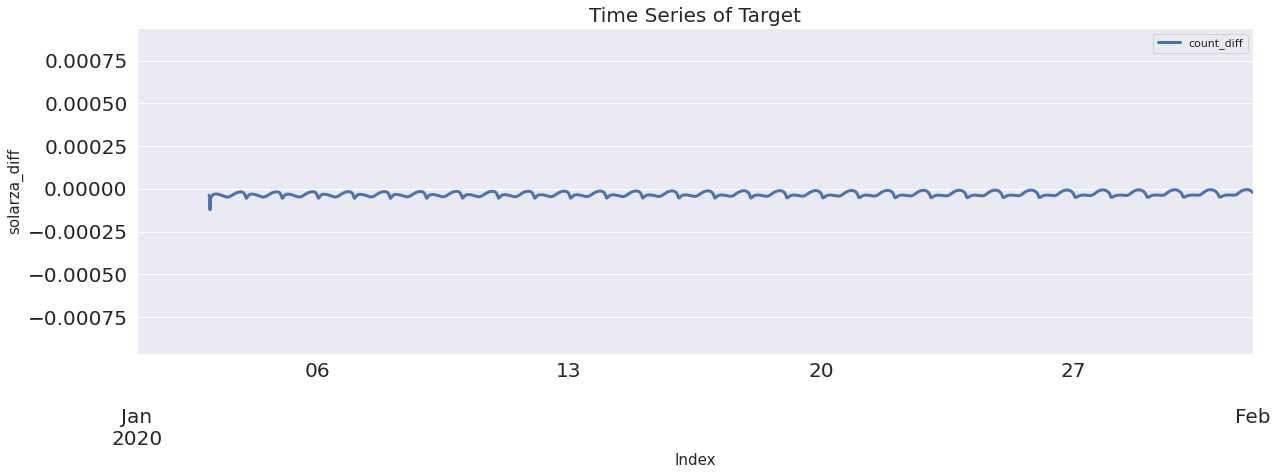

In [ ]:
df_146[['solarza']].diff(144).diff(144).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2020-01-01', '2020-02-01'),)
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('solarza_diff', fontsize=15)
plt.legend(['count_diff'])
plt.show()

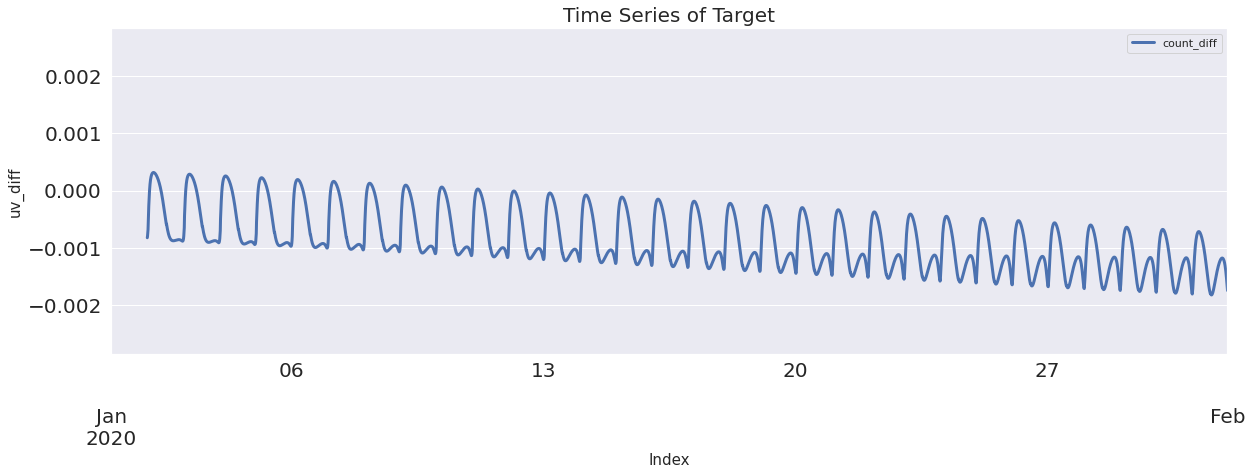

In [ ]:
df_146[['solarza']].diff(144).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2020-01-01', '2020-02-01'),)
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('uv_diff', fontsize=15)
plt.legend(['count_diff'])
plt.show()

In [ ]:
df_146 = stn_split(df,146)

In [ ]:
def x_diff(df:pd.DataFrame,x:str,n:int)->pd.DataFrame:
  df_diff = df.copy()
  if f'{x}_{n}' not in df_diff.columns:
    df_diff[f'{x}_{n}'] = df_diff[x].diff(n).bfill()
  return df_diff

In [ ]:
for x in x_list:
  for diff_num in (144,1):
    df_146 = x_diff(df_146,x,diff_num)


In [ ]:
def x_rolling(df:pd.DataFrame,x:str)->pd.DataFrame:
  df_rolling = df.copy()
  if f'{x}_ma' not in df_rolling.columns:
    df_rolling[f'{x}_ma'] = df_rolling[x].rolling(144).mean().bfill()
  return df_rolling

In [ ]:
for x in x_list:
    df_146 = x_rolling(df_146,x)

In [ ]:
df_146.columns

Index(['uv', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7',
       'band8', 'band9', 'band10', 'band11', 'band12', 'band13', 'band14',
       'band15', 'band16', 'solarza', 'esr', 'Month sin', 'Month cos',
       'Day sin', 'Day cos', '2/Day sin', '2/Day cos', '3/Day sin',
       '3/Day cos', 'solarza_144', 'solarza_1', 'esr_144', 'esr_1',
       'band1_144', 'band1_1', 'band2_144', 'band2_1', 'band3_144', 'band3_1',
       'band4_144', 'band4_1', 'band6_144', 'band6_1', 'band7_144', 'band7_1',
       'band12_144', 'band12_1', 'solarza_ma', 'esr_ma', 'band1_ma',
       'band2_ma', 'band3_ma', 'band4_ma', 'band6_ma', 'band7_ma',
       'band12_ma'],
      dtype='object')

In [ ]:
df_146_nsol = df_146.drop(['solarza','esr'],axis=1)

In [ ]:
lgbr = lgb.LGBMRegressor(n_jobs=-1,randoms_state=42)
cbr = cb.CatBoostRegressor(random_state=42)
ef = ensemble.ExtraTreesRegressor(n_jobs=-1,random_state=42)
rf = ensemble.RandomForestRegressor(n_jobs=-1,random_state=42)
xbgr = xgb.XGBRegressor(random_state=42)
knn = KNeighborsRegressor(n_jobs=-1)
models = [
          lgbr,
          cbr,
          ef,
          xbgr,
          rf]
for model in tqdm(models):
  model.fit(df_146_nsol.iloc[:,1:],df_146_nsol['uv'])

100%|██████████| 5/5 [03:57<00:00, 47.53s/it]


5it [10:21, 124.34s/it]


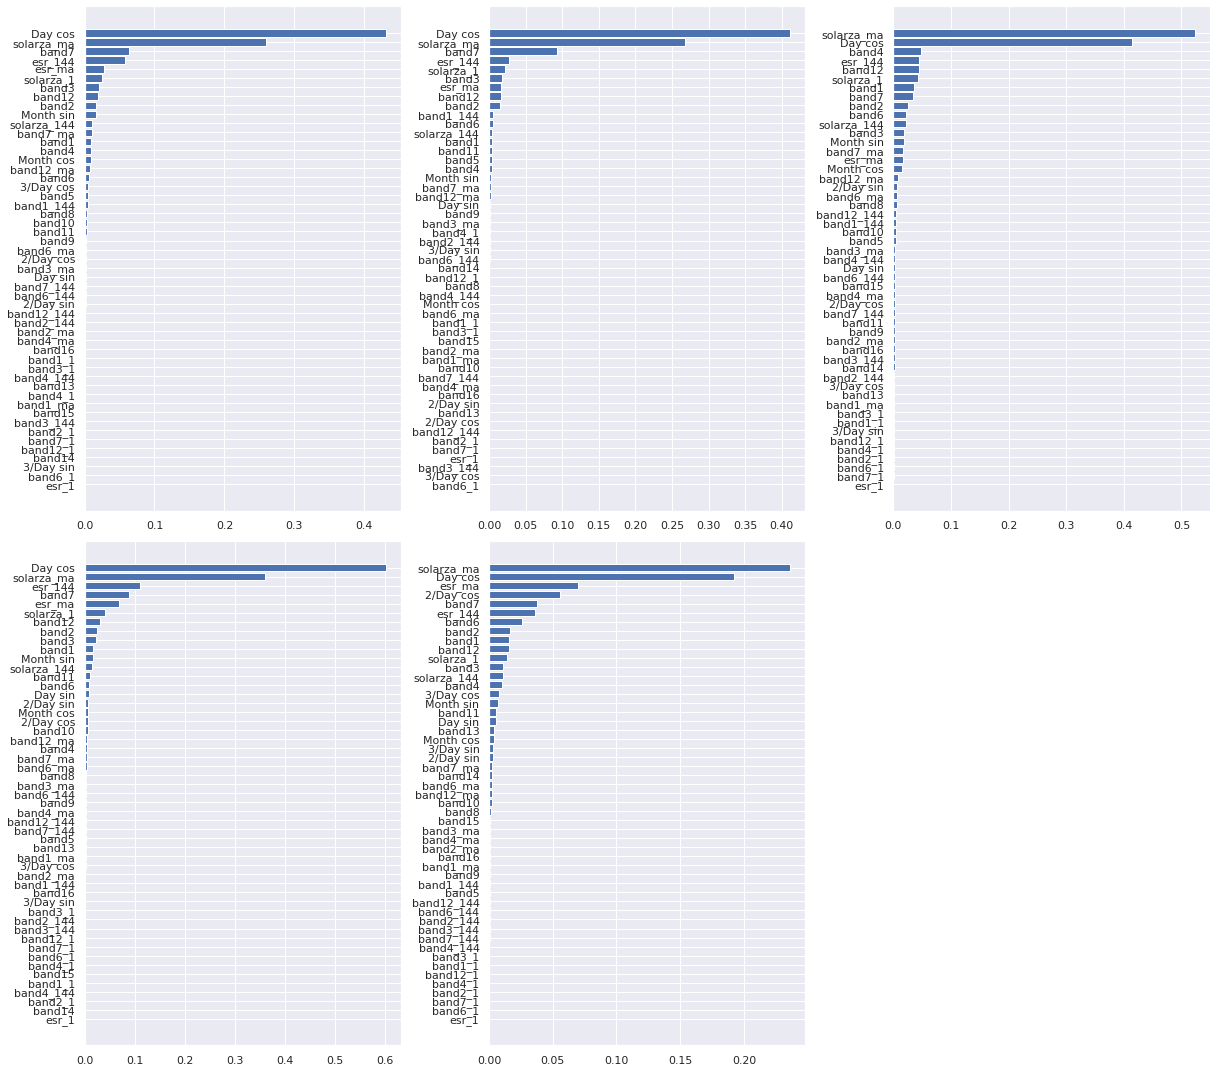

In [ ]:
fig = plt.figure(figsize=(17,15))
ax = [] 
for i in range(1,6):
  ax.append(fig.add_subplot(2,3,i))

for i,model in tqdm(enumerate([lgbr,xbgr,cbr,rf,ef])):
  result = permutation_importance(model,
                                  df_146_nsol.iloc[:,1:],
                                  df_146_nsol['uv'],
                                  random_state=42)
  sorted_idx = result.importances
  sorted_idx = result.importances_mean.argsort()
  ax[i].barh(df_146_nsol.iloc[:,1:].columns[sorted_idx],
           result.importances_mean[sorted_idx]) 

plt.tight_layout()

In [ ]:
df_146 = stn_split(df, 146)
df_146['year'] = df_146.index.year

In [ ]:
stat,p = stats.ttest_ind(df_146.loc[df_146['year']==2020, 'uv'],
                         df_146.loc[df_146['year']==2021, 'uv'])


In [ ]:
print(f't통계량 : {round(stat,2)},\np-value : {round(p,2)}')

t통계량 : 17.24,
p-value : 0.0
